In [22]:
# import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [23]:
def good_matches_func(frame1, frame2):
    
    # Extract keypoints of images
    sift = cv2.SIFT_create()
    f1_kp, f1_des = sift.detectAndCompute(frame1, None)
    f2_kp, f2_des = sift.detectAndCompute(frame2, None)

    # Use BFMatcher to find corresponding points
    bfm_object = cv2.BFMatcher()
    
    # Define knnMatch k=2
    matches = bfm_object.knnMatch(f1_des, f2_des, k=2)

    # PartB: find appropriate corresponding points
    good_matches = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            good_matches.append(m)
    return good_matches, f1_kp, f2_kp

In [24]:
# Part D to H
def two_frames(
    panorama, new_frame, f1_kp, f2_kp, good_matches):
    #PartD: Find the Homography matrix using corresponding points
    dst_pts = np.float32(
        [f1_kp[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    src_pts = np.float32([
        f2_kp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    
    H, _ = cv2.findHomography(
        src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5.0)

    #PartE: Use warpPerspective and Homography matrix to
    h1,w1 = panorama.shape[0], panorama.shape[1]
    h2,w2 = new_frame.shape[0], new_frame.shape[1]
    warped_frame = cv2.warpPerspective(
        new_frame, H, (w1 + w2, h1 + h2))

    # PartF: Create a new panorama with a new mask
    whiteFrame = 255 * np.ones((h2,w2), np.uint8)
    warped_mask = cv2.warpPerspective(
        whiteFrame, H, (w1 + w2, h1 + h2))
    # Compute edges using the Canny edge detector
    edges = cv2.Canny(warped_mask,100,200)

    # PartG
    # Convert warped_mask and edges imageS to three-channel images
    # to apply numpy where method
    warped_mask_3 = cv2.cvtColor(warped_mask, cv2.COLOR_GRAY2BGR)
    edges_3 = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    # replace corresponding non-white and edges pixels with panorama
    warped_frame[0:h1, 0:w1] = np.where(
                               ((warped_mask_3[0:h1, 0:w1]!=255) |
                                (edges_3[0:h1, 0:w1]==255)),
                                 panorama, warped_frame[0:h1, 0:w1])

    # PartH
    # Crop the color image based on non-zero rows and columns
    one_channel_warped = cv2.cvtColor(
        warped_frame, cv2.COLOR_BGR2GRAY)
    # Remove zero rows
    panorama_row_zeros = warped_frame[
        ~np.all(one_channel_warped == 0, axis=1)]

    # Remove zero columns
    panorama = panorama_row_zeros[:,
        ~np.all(one_channel_warped == 0, axis=0)]

    return panorama

In [25]:
def panorama(frames):
    
    frame_idx = 0
    panorama = None

    # Variable to ensure that the initial panorama is created
    make_initial_panorama = True
    while make_initial_panorama:

        frame1, frame2 = frames[0], frames[1+frame_idx]
        # Parts A and B
        good_matches, f1_kp, f2_kp = good_matches_func(frame1, frame2)

        # PartC: If 4 pairs of points exist in the
        # suitable corresponding points, then we could
        # create a panorama, otherwise, we should consider
        # another frame
        if len(good_matches) >= 4:
            make_initial_panorama = False
        else:
            print("frame not valid")
            frame_idx +=1
            continue
        # Other parts(each part is described uniquely)
        panorama = two_frames(frame1, frame2,
                           f1_kp, f2_kp, good_matches)

    # Other frames
    for i in range(2+frame_idx,(len(frames)),1):
        frame1, frame2 = panorama, frames[i]
        # Parts A and B
        good_matches, f1_kp, f2_kp = good_matches_func(frame1,frame2)
        if len(good_matches) < 4:
            print("frame not valid")
            continue
        panorama = two_frames(frame1, frame2,f1_kp, f2_kp, good_matches)

    return panorama

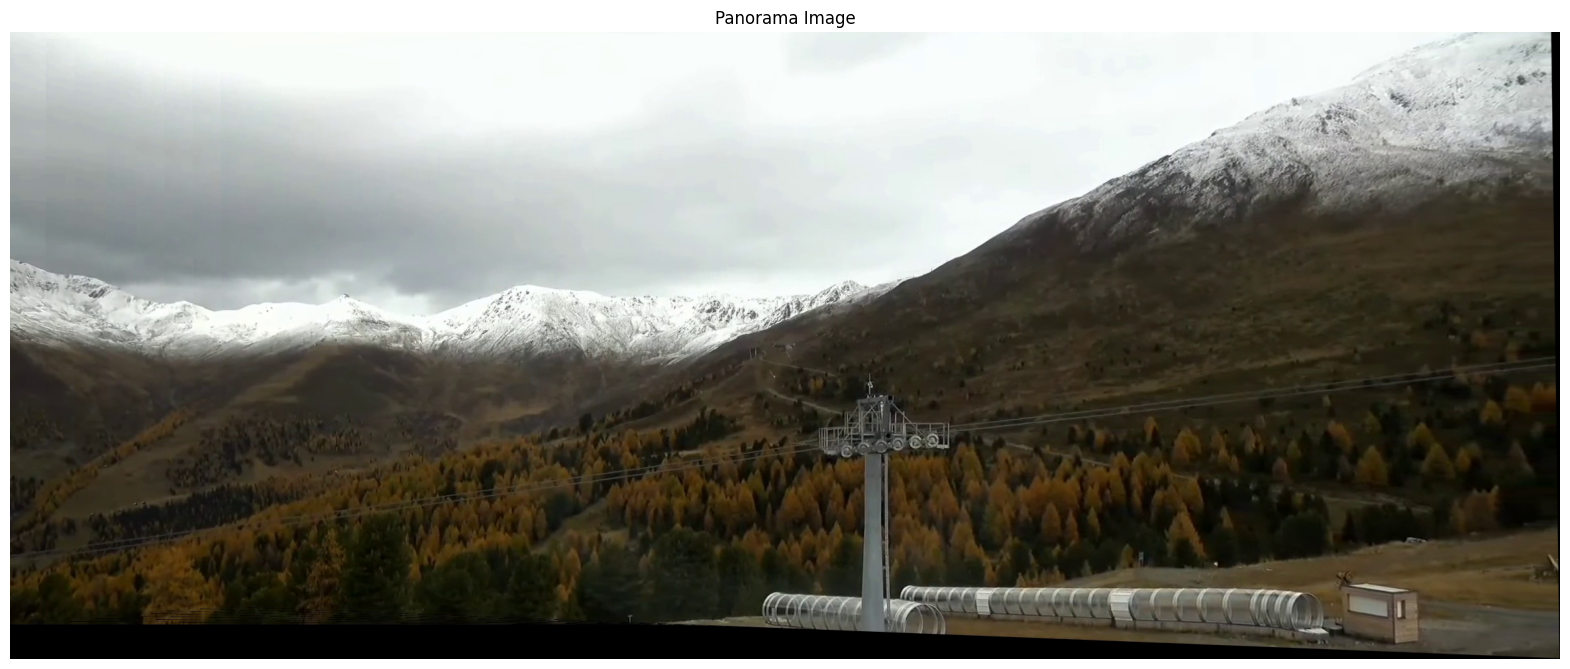

In [26]:
# Read frames of the video
cap = cv2.VideoCapture('video.mp4')

frames = []
count_frame = 1

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Append frames
    if count_frame%20 == 1:
        frames.append(frame)
    count_frame +=1
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Apply panorama function
panorama_gray = panorama(frames)

# Convert to RGB
panorama_image = panorama_gray[...,::-1]

# Plot final result
plt.figure(figsize=(20,20))
plt.title("Panorama Image")
plt.imshow(panorama_image)
plt.axis('off')
plt.show()